# CAPSTON PROJECT

---



## STEP 1: LOAD and IMPORT LIBRARIES

---



In [1]:
import os
import re
import string
import psycopg2
import getpass
import pandas as pd
import numpy as np

## STEP 2: IMPORT DATA

---



In [2]:
# Request user for password to access database
db_password = getpass.getpass(prompt='DB Password ')

# Create SQL engine with connection parameters to connect to AWS RDS Postgres instance
engine = psycopg2.connect(
    database="Capstone_Project_Group_9",
    user="postgres",
    password=db_password,
    host="capstone-project-group-9.c4857qrbkptn.us-east-2.rds.amazonaws.com",
    port='5432'
)

# Show sample of the imported data
dataset_df = pd.read_sql('SELECT * FROM fake_job_postings', engine)
dataset_df.head(1)

DB Password ········


,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,US; NY; New York,Marketing,None,We're Food52 and we've created a groundbreakin...,Food52 a fast-growing James Beard Award-winnin...,Experience with content management systems a m...,None,0,1,0,Other,Internship,None,None,Marketing,0


In [3]:
# Drop columns with too many null values or where all values are unique
dataset_df = dataset_df.drop(columns=['job_id','salary_range','title'])

In [4]:
# Display number of null values for each column
dataset_df.isnull().sum()

location                 346
department             11547
company_profile         3308
description                0
requirements            2694
benefits                7206
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

In [5]:
# Split the location columns by the seperator and only keep the country
# Only country is kept due to misspelled states and cities and some rows have multiple states and cities
# that do not have a seperator
dataset_df['Country'] = dataset_df['location'].str.split(';').str[0]
dataset_df = dataset_df.drop(columns=['location'])
dataset_df.head(1)

,department,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,Country
0,Marketing,We're Food52 and we've created a groundbreakin...,Food52 a fast-growing James Beard Award-winnin...,Experience with content management systems a m...,None,0,1,0,Other,Internship,None,None,Marketing,0,US


In [6]:
# Replace null values with "not specified" string
dataset_df = dataset_df.fillna('not specified')
dataset_df.head(1)

,department,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,Country
0,Marketing,We're Food52 and we've created a groundbreakin...,Food52 a fast-growing James Beard Award-winnin...,Experience with content management systems a m...,not specified,0,1,0,Other,Internship,not specified,not specified,Marketing,0,US


In [7]:
# Define columns that need to be cleaned
clean_cols = ["company_profile", "description", "requirements", "benefits"]
# Loop through clean_cols and remove punctuation and characters
for col in clean_cols:
    dataset_df[col] = dataset_df[col].replace(r'[^a-zA-Z0-9\s]', '',regex=True)
    dataset_df[col] = dataset_df[col].replace(r'\s{2,}', '',regex=True)

dataset_df.head(1)

,department,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,Country
0,Marketing,Were Food52 and weve created a groundbreaking ...,Food52 a fastgrowing James Beard Awardwinning ...,Experience with content management systems a m...,not specified,0,1,0,Other,Internship,not specified,not specified,Marketing,0,US


In [8]:
# check the number of null values in columns
dataset_df.isnull().sum()

department             0
company_profile        0
description            0
requirements           0
benefits               0
telecommuting          0
has_company_logo       0
has_questions          0
employment_type        0
required_experience    0
required_education     0
industry               0
function               0
fraudulent             0
Country                0
dtype: int64

In [9]:
# Remove any whitespace from the country, city and state columns
### code is kept for future compatibility ###
#dataset_df['Country'] = dataset_df['Country'].map(lambda x: x.strip())

#dataset_df.head()

In [10]:
# make all text lower case
string_cols = list(dataset_df.select_dtypes(include='object'))
for col in string_cols:
    dataset_df[col] = dataset_df[col].str.lower()

#dataset_df.head()

In [11]:
# Get number of unique values in each column
dataset_df.nunique()

department              1284
company_profile         1710
description            14727
requirements           11911
benefits                6022
telecommuting              2
has_company_logo           2
has_questions              2
employment_type            6
required_experience        8
required_education        14
industry                 132
function                  38
fraudulent                 2
Country                   91
dtype: int64

## Step 3: Feature encoding

---



In [12]:
# Import libraries required for encoding
from category_encoders import BinaryEncoder
from sklearn.preprocessing import LabelEncoder
from category_encoders import TargetEncoder

In [13]:
# Define Ordinal and Nominal columns
nom_cols = ['department', 'industry', 'function', 'Country']
ord_cols = ['employment_type','required_experience','required_education']

In [14]:
# Run TargetEncoder on nominal columns
Targetenc = TargetEncoder()
for col in nom_cols:
    values = Targetenc.fit_transform(X = dataset_df[col], y = dataset_df['fraudulent'])
    dataset_df[col] = values[col]

dataset_df.head(2)

C:\Users\Khashayar\anaconda3\envs\mlenv\lib\site-packages\category_encoders\target_encoder.py:94: FutureWarning: Default parameter min_samples_leaf will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  category=FutureWarning)
C:\Users\Khashayar\anaconda3\envs\mlenv\lib\site-packages\category_encoders\target_encoder.py:99: FutureWarning: Default parameter smoothing will change in version 2.6.See https://github.com/scikit-learn-contrib/category_encoders/issues/327
  category=FutureWarning)


,department,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,Country
0,0.004963,were food52 and weve created a groundbreaking ...,food52 a fastgrowing james beard awardwinning ...,experience with content management systems a m...,not specified,0,1,0,other,internship,not specified,0.056088,0.012048,0,0.068506
1,0.000871,90 seconds the worlds cloud video production s...,organisedfocusedvibrantawesomedo you have a pa...,what we expect from youyour key responsibility...,what you will get from usthrough being part of...,0,1,0,full-time,not applicable,not specified,0.054348,0.054516,0,0.000000


In [15]:
# Run labelEncoder on Ordinal columns
le = LabelEncoder()
for col in ord_cols:
    dataset_df[col] = le.fit_transform(dataset_df[col])

In [16]:
# rename all columns to have data_ prefix for easy feature identification in machine learning model
for col in dataset_df.columns:
    dataset_df.rename(columns = {col:f'data_{col}'}, inplace = True)
    
# update clean_cols to have new column names    
clean_cols = ["data_company_profile", "data_description", "data_requirements", "data_benefits"]

In [17]:
dataset_df.head(1)

,data_department,data_company_profile,data_description,data_requirements,data_benefits,data_telecommuting,data_has_company_logo,data_has_questions,data_employment_type,data_required_experience,data_required_education,data_industry,data_function,data_fraudulent,data_Country
0,0.004963,were food52 and weve created a groundbreaking ...,food52 a fastgrowing james beard awardwinning ...,experience with content management systems a m...,not specified,0,1,0,3,4,6,0.056088,0.012048,0,0.068506


In [18]:
dataset_df.dtypes

data_department             float64
data_company_profile         object
data_description             object
data_requirements            object
data_benefits                object
data_telecommuting            int64
data_has_company_logo         int64
data_has_questions            int64
data_employment_type          int32
data_required_experience      int32
data_required_education       int32
data_industry               float64
data_function               float64
data_fraudulent               int64
data_Country                float64
dtype: object

## Step 4: Tockenizing

---



### NLTK 

In [19]:
# Import libraries for NLTK and sklearn
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Khashayar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [20]:
# create stopwords
stop = stopwords.words('english')

In [21]:
# for each column in clean_cols remove stopwords
for col in clean_cols:
  dataset_df[col] = dataset_df[col].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [22]:
# Run Stemming on clean_cols
porter = PorterStemmer()

for col in clean_cols:
  dataset_df[col] = dataset_df[col].apply(porter.stem)

In [23]:
# Combine all columns in clean_cols into single text column and create new column witi length of text
dataset_df['combined_text'] = dataset_df['data_company_profile'] + dataset_df['data_description'] + dataset_df['data_requirements'] + dataset_df['data_benefits']
#dataset_df['combined_text_length'] = dataset_df['combined_text'].str.len()

# Create list of columns for vectorization
num_cols = list(dataset_df.select_dtypes(include=['int64','float64']))
num_cols.append('combined_text')

### View Resulting Output from NLTK

In [24]:
dataset_df.head(2)

,data_department,data_company_profile,data_description,data_requirements,data_benefits,data_telecommuting,data_has_company_logo,data_has_questions,data_employment_type,data_required_experience,data_required_education,data_industry,data_function,data_fraudulent,data_Country,combined_text
0,0.004963,food52 weve created groundbreaking awardwinnin...,food52 fastgrowing james beard awardwinning on...,experience content management systems major pl...,specifi,0,1,0,3,4,6,0.056088,0.012048,0,0.068506,food52 weve created groundbreaking awardwinnin...
1,0.000871,90 seconds worlds cloud video production servi...,organisedfocusedvibrantawesomedo passion custo...,expect youyour key responsibility communicate ...,get usthrough part 90 seconds team gainexperie...,0,1,0,1,6,6,0.054348,0.054516,0,0.000000,90 seconds worlds cloud video production servi...


In [25]:
# Create dataframe with only required columns for vectorization
vector_df = dataset_df[num_cols]

In [26]:
vector_df.head(1)

,data_department,data_telecommuting,data_has_company_logo,data_has_questions,data_industry,data_function,data_fraudulent,data_Country,combined_text
0,0.004963,0,1,0,0.056088,0.012048,0,0.068506,food52 weve created groundbreaking awardwinnin...


In [27]:
# Create Term freqeuncy Vectorizer
tfidf_vect = TfidfVectorizer(use_idf=True,
                      smooth_idf=True,
                      min_df = 1,
                      stop_words = 'english',
                      max_features = 1000)

In [28]:
# Run term frequency vectorizor
term_freq_idf_df = pd.DataFrame(tfidf_vect.fit_transform(vector_df['combined_text']).toarray(), columns=tfidf_vect.get_feature_names_out())

In [29]:
term_freq_idf_df.head(2)

,10,100,12,20,200,30,401k,50,90,ability,...,worldwide,write,writing,written,year,years,york,youll,young,youre
0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.269674,0.0,0.0,0.0
1,0.0,0.05194,0.0,0.0,0.0,0.051452,0.0,0.057302,0.255256,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


### Create DF ready for Machine Learning

In [30]:
# Merge vector_df with term frequency vectorizor output
ml_df = vector_df.merge(term_freq_idf_df, left_index=True, right_index=True, how='inner')

In [31]:
# drop the original text column
ml_df.drop('combined_text',axis=1,inplace=True)

In [32]:
ml_df.head(2)

,data_department,data_telecommuting,data_has_company_logo,data_has_questions,data_industry,data_function,data_fraudulent,data_Country,10,100,...,worldwide,write,writing,written,year,years,york,youll,young,youre
0,0.004963,0,1,0,0.056088,0.012048,0,0.068506,0.0,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.269674,0.0,0.0,0.0
1,0.000871,0,1,0,0.054348,0.054516,0,0.000000,0.0,0.05194,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


## Step 5: Machine Learning
ml_df is the dataframe ready for machine learning
---

In [33]:
# Selecting our feature and target variables
from sklearn.model_selection import train_test_split
x = ml_df.drop('data_fraudulent',axis=1)
y = ml_df.data_fraudulent

# splitting the dataset into training and testing
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=1,stratify=y)

In [34]:
# Importing required libraries for LightGBM model
import lightgbm as lgb
from sklearn import metrics
from datetime import datetime

In [35]:
#setting up the parameters for our LightGBM model and training our model
model_lightgbm = lgb.LGBMClassifier(num_iteration=250,learning_rate=0.08,max_depth=7,random_state=1,bagging_fraction=0.9)
lgb_start = datetime.now()
model_lightgbm.fit(x_train,y_train, eval_set=[(x_test,y_test),(x_train ,y_train)], verbose=50, eval_metric='logloss')
lgb_stop = datetime.now()

C:\Users\Khashayar\anaconda3\envs\mlenv\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\Khashayar\anaconda3\envs\mlenv\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] num_iterations is set=250, num_iteration=250 will be ignored. Current value: num_iterations=250
[50]	training's binary_logloss: 0.0327487	valid_0's binary_logloss: 0.0634416
[100]	training's binary_logloss: 0.018298	valid_0's binary_logloss: 0.0567066
[150]	training's binary_logloss: 0.0114729	valid_0's binary_logloss: 0.0542846
[200]	training's binary_logloss: 0.00780895	valid_0's binary_logloss: 0.0535161
[250]	training's binary_logloss: 0.00521191	valid_0's binary_logloss: 0.0534444


In [36]:
#Execution time of the LightGBM model 
execution_time_lgb = lgb_stop - lgb_start

In [37]:
# printing the accuracy of the model during training
print('Training accuracy of the lightgbm model is  {:.4f}'.format(model_lightgbm.score(x_train,y_train)))

Training accuracy of the lightgbm model is  0.9997


In [38]:
# printing the accuracy of the model during Testing
print('Testing accuracy of the lightgbm model is  {:.4f}'.format(model_lightgbm.score(x_test,y_test)))

Testing accuracy of the lightgbm model is  0.9832


In [39]:
# calculating accuracy of our model 
accuracy_lgb = model_lightgbm.score(x_test,y_test)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

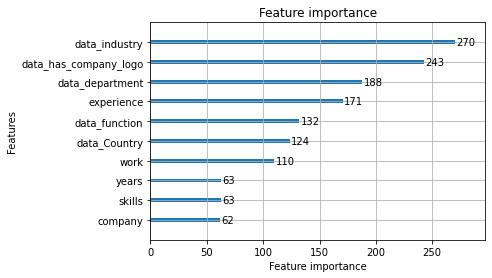

In [40]:
# Plotting the important features
lgb.plot_importance(model_lightgbm, max_num_features=10)

<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='binary_logloss'>

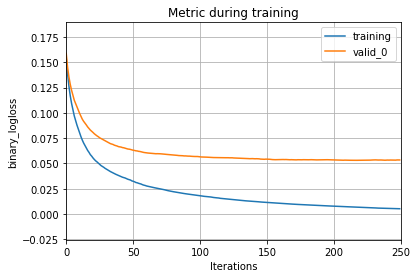

In [41]:
# Graphing the learning curve for LightGBM model
lgb.plot_metric(model_lightgbm)

In [42]:
# Classification report for Training LightGBM
print(metrics.classification_report(y_train,model_lightgbm.predict(x_train)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13611
           1       1.00      0.99      1.00       693

    accuracy                           1.00     14304
   macro avg       1.00      1.00      1.00     14304
weighted avg       1.00      1.00      1.00     14304



In [43]:
# Classification report for Testing LightGBM
print(metrics.classification_report(y_test,model_lightgbm.predict(x_test)))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3403
           1       0.93      0.71      0.80       173

    accuracy                           0.98      3576
   macro avg       0.96      0.85      0.90      3576
weighted avg       0.98      0.98      0.98      3576



In [44]:
# Splitting Training classification report into its components for LightGBM
from sklearn.metrics import precision_recall_fscore_support as score
precision,recall,fscore,support=score(y_train,model_lightgbm.predict(x_train))
print ('Precision : {}'.format(precision))
print ('Recall    : {}'.format(recall))
print ('F-score   : {}'.format(fscore))
print ('Support   : {}'.format(support))

Precision : [0.99963278 1.        ]
Recall    : [1.         0.99278499]
F-score   : [0.99981636 0.99637944]
Support   : [13611   693]


In [45]:
# Splitting Testing classification report into its components for LightGBM
precision,recall,fscore,support=score(y_test,model_lightgbm.predict(x_test))
lgb_recall = score(y_test,model_lightgbm.predict(x_test))[1]
lgb_recall_0 = lgb_recall[0]
lgb_recall_1 = lgb_recall[1]

C:\Users\Khashayar\anaconda3\envs\mlenv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


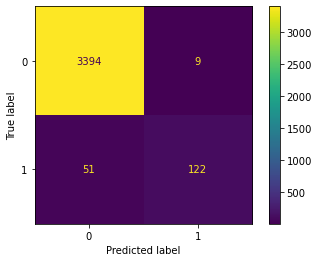

In [46]:
# Plotting confusion matrix for LightGBM model
metrics.plot_confusion_matrix(model_lightgbm,x_test,y_test)

In [47]:
# Importing required libraries for XGBoost model
import xgboost as xgb
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

In [48]:
#setting up the parameters for our XGBoost model and training our model
model_xgboost = xgb.XGBClassifier(objective='binary:logistic', missing=1, seed= 42, random_state=42)
xgb_start = datetime.now()
model_xgboost.fit(x_train, y_train, eval_set=[(x_test,y_test),(x_train,y_train)], verbose=50, eval_metric='logloss')
xgb_stop=datetime.now()

C:\Users\Khashayar\anaconda3\envs\mlenv\lib\site-packages\xgboost\sklearn.py:797: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  UserWarning,


[0]	validation_0-logloss:0.46259	validation_1-logloss:0.46093
[50]	validation_0-logloss:0.05269	validation_1-logloss:0.01529
[99]	validation_0-logloss:0.05142	validation_1-logloss:0.00663


In [49]:
# Execution time of the XGBoost model 
execution_time_xgb = xgb_stop - xgb_start 

In [50]:
# calculating accuracy of XGBoost model 
accuracy_xgb = model_xgboost.score(x_test,y_test)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

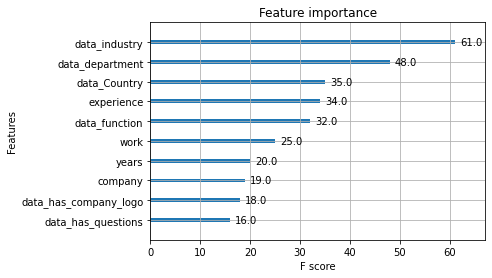

In [51]:
# Plotting the important features for XGBoost model
xgb.plot_importance(model_xgboost, max_num_features=10)

In [52]:
results = model_xgboost.evals_result()
epochs = len(results['validation_0']['logloss'])
x_axis = range(0, epochs)

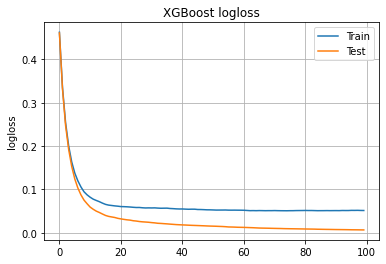

In [53]:
# Plotting the learning curve for XGBoost model
from matplotlib import pyplot
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
pyplot.ylabel('logloss')
pyplot.title('XGBoost logloss')
pyplot.grid()
pyplot.show()

C:\Users\Khashayar\anaconda3\envs\mlenv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


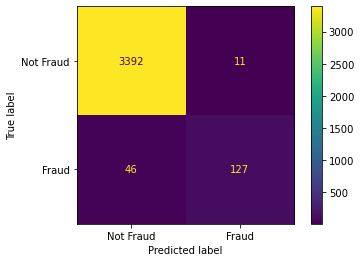

In [54]:
# Plotting the confusion matrix for XGBoost model
plot_confusion_matrix(model_xgboost, 
                      x_test, 
                      y_test, 
                      values_format='d',
                      display_labels=['Not Fraud','Fraud'])

In [55]:
# # Classification report for Training XGBoost
print(metrics.classification_report(y_train,model_xgboost.predict(x_train)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13611
           1       1.00      0.99      0.99       693

    accuracy                           1.00     14304
   macro avg       1.00      0.99      1.00     14304
weighted avg       1.00      1.00      1.00     14304



In [56]:
# Classification report for Testing XGBoost
print(metrics.classification_report(y_test,model_xgboost.predict(x_test)))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3403
           1       0.92      0.73      0.82       173

    accuracy                           0.98      3576
   macro avg       0.95      0.87      0.90      3576
weighted avg       0.98      0.98      0.98      3576



In [57]:
# Splitting Training classification report into its components for XGBoost
precision,recall,fscore,support= score(y_train,model_xgboost.predict(x_train))
print ('Precision : {}'.format(precision))
print ('Recall    : {}'.format(recall))
print ('F-score   : {}'.format(fscore))
print ('Support   : {}'.format(support))

Precision : [0.99941259 1.        ]
Recall    : [1.         0.98845599]
F-score   : [0.99970621 0.99419448]
Support   : [13611   693]


In [58]:
# Splitting Testing classification report into its components for XGBoost
precision,recall,fscore,support= score(y_test,model_xgboost.predict(x_test))
xgb_recall = score(y_test,model_xgboost.predict(x_test))[1]
xgb_recall_0 = xgb_recall[0]
xgb_recall_1 = xgb_recall[1]

In [59]:
# Creating comparison dictionary
comparison_dict = {'accuracy score':(accuracy_lgb,accuracy_xgb),'Recall 0':(lgb_recall_0, xgb_recall_0),'Recall 1':(lgb_recall_1, xgb_recall_1), 'execution time':(execution_time_lgb, execution_time_xgb)}

# Creating a dataframe ‘comparison_df’ for comparing the performance of Lightgbm and xgb. 
comparison_df = pd.DataFrame(comparison_dict) 
comparison_df.index= ['LightGBM','XGBoost'] 
comparison_df

,accuracy score,Recall 0,Recall 1,execution time
LightGBM,0.983221,0.997355,0.705202,0 days 00:00:14.764873
XGBoost,0.984060,0.996768,0.734104,0 days 00:00:28.259019
